# q.4 Do additional officers improve a county's clearance rate?


My contribution to a group final project for DiDa 325, analyzing whether additional police officers improve crime clearance rates in NY counties. Uses econometric methods to test the relationship between officer staffing levels and crime solving effectiveness.


## Discussion

To investigate whether increasing police officer staffing improves crime clearance rates at the county level in New York State, the fundamental policy question that needs to be answered is whether additional law enforcement resources translate into more effective crime solving. To answer this, I employed OLS regression with log-transformed cleared crimes as the dependent variable to avoid mechanical correlation issues inherent in using clearance rates directly. To further prevent correlation issues, officers-per-crime ratios were used rather than raw employment figures to address multicollinearity and better capture resource allocation intensity(essentially representing coverage by police force). The square of this varriable was also added to capture any diminishing returns with officer employment and clearance rates.

The final model chosen for estimation was:

 log(total_cleared) = β₀ + β₁(new_total_crime) + β₂(officers_per_crime) + β₃(officers_per_crime²) + controls

Basic analysis of officer per crime coefficient reveals a negative relationship, suggesting a 1% increase in officer to crime ratio leads to an 8.5% decrease in total clearance. More rigorous analysis revealed a surprising U-shaped relationship between officer coverage and clearance effectiveness. While the quadratic term wasn't individually significant (p=0.051), joint significance F-tests confirmed a non-linear relationship between officer coverage and clearance rates. Residual analysis and mean residual also suggest that the model shouldn't suffer from bias (the error mean independence assumption should be achieved). Before conducting hypothesis testing, a Breusch-Pagan test was conducted to check for heteroskedasticity, which revealed a heteroskedasticity problem. Robust SEs were computed to fix this.


However, to see and test the effectiveness of ADDITIONAL officers, analysis and testing of the marginal effect of additional officer coverage on clearance rates is required. This marginal effect can be represented by:

 ∂log(total_cleared)/∂(officers_per_crime) = β₂ + 2β₃(officers_per_crime)

To test whether marginal increases in police force helped with clearance rates, the marginal effect of the average county officer coverage (and its SE) is calculated, and the following hypothesis test is drawn:

 H₀: β₂ + 2β₃(mean) ≤ 0
 H₁: β₂ + 2β₃(mean) > 0

Using a one-sided t-test reveals that, while the marginal effect is statistically significant, it's significant in the opposite direction. Meaning the average county in New York gets lower clearance rates when additional officers are hired. However, the u-shape and existence of a critical point all suggest that a benefit DOES exist after an officer-to-crime ratio of over 1.16. The most realistic explanation is that an opportunity cost exists before 1.16 officers per crime ratio is reached. While the model can't speak on what might the opportunity cost be, some realistic options include training/ability, administrative burden for smaller counties, or resource constraints.

# code

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.metrics import mean_absolute_error

In [132]:
#dataset given for project
cc = pd.read_csv("https://media.githubusercontent.com/media/themarshallproject/crime-clearance-rate/refs/heads/main/crime_clearance_rate.csv")

'''
The following code is necessary for feature engineering
'''


fips = {
  "Albany": 36001,
  "Allegany": 36003,
  "Broome": 36007,
  "Cattaraugus": 36009,
  "Cayuga": 36011,
  "Chautauqua": 36013,
  "Chemung": 36015,
  "Chenango": 36017,
  "Clinton": 36019,
  "Columbia": 36021,
  "Cortland": 36023,
  "Delaware": 36025,
  "Dutchess": 36027,
  "Erie": 36029,
  "Essex": 36031,
  "Franklin": 36033,
  "Fulton": 36035,
  "Genesee": 36037,
  "Greene": 36039,
  "Hamilton": 36041,
  "Herkimer": 36043,
  "Jefferson": 36045,
  "Lewis": 36049,
  "Livingston": 36051,
  "Madison": 36053,
  "Monroe": 36055,
  "Montgomery": 36057,
  "Nassau": 36059,
  "New York City": 36061,
  "Niagara": 36063,
  "Oneida": 36065,
  "Onondaga": 36067,
  "Ontario": 36069,
  "Orange": 36071,
  "Orleans": 36073,
  "Oswego": 36075,
  "Otsego": 36077,
  "Putnam": 36079,
  "Rensselaer": 36083,
  "Rockland": 36087,
  "Saratoga": 36091,
  "Schenectady": 36093,
  "Schoharie": 36095,
  "Schuyler": 36097,
  "Seneca": 36099,
  "St Lawrence": 36089,
  "Steuben": 36101,
  "Suffolk": 36103,
  "Sullivan": 36105,
  "Tioga": 36107,
  "Tompkins": 36109,
  "Ulster": 36111,
  "Warren": 36113,
  "Washington": 36115,
  "Wayne": 36117,
  "Westchester": 36119,
  "Wyoming": 36121,
  "Yates": 36123
}

nyc_borough_fips = [
    36005,  # Bronx
    36047,  # Brooklyn
    36061,  # Manhattan
    36081,  # Queens
    36085   # Staten Island
]

# Function to convert borough FIPS to the single NYC FIPS
def consolidate_nyc_fips(fips):
    if fips in nyc_borough_fips:
        return 36061
    else:
        return fips

In [126]:


#fix clearance data
state = cc[cc['state'] == 'new york']
state['fips_state_county_code'] = state['fips_state_county_code'].apply(consolidate_nyc_fips)

clearance_data = state[['ori','fips_state_county_code', 'year', 'new_total_crime', 'cleared_total_crime', 'new_violent_crime' ]]

clearance_data = clearance_data.groupby(['fips_state_county_code', 'year']).agg({
    'new_total_crime': 'sum',
    'cleared_total_crime': 'sum',
    'new_violent_crime' : 'sum'
}).reset_index()

clearance_data = clearance_data[clearance_data['year'] >= 2007]
clearance_data['log_cleared'] = np.log(clearance_data['cleared_total_crime']) #calculate clearance RATE with log instead of ratio to avoid correlation and bias issues
clearance_data['log_crime'] = np.log(clearance_data['new_violent_crime']) #calculate clearance RATE with log instead of ratio to avoid correlation and bias issues

#load police data
path = 'https://raw.githubusercontent.com/ngutin1/dida/refs/heads/main/Law_Enforcement_Personnel_by_Agency___Beginning_2007_20250505.csv'
ny = pd.read_csv(path) #https://data.ny.gov/Public-Safety/Law-Enforcement-Personnel-by-Agency-Beginning-2007/khn9-hhpq/about_data
police_data = ny[['County', 'Year', 'Grand Total']]

police_data = police_data.groupby(['County', 'Year']).agg({
    'Grand Total': 'sum'
}).reset_index()

police_data['fips'] = police_data['County'].map(fips)


#merge two dfs to create training data
clearance_data = clearance_data.rename(columns = {'fips_state_county_code':'fips', 'year':'Year'})
police_data = police_data.rename(columns = {'Grand Total':'officers_employed'})

training = pd.merge(
    clearance_data,
    police_data,
    on=['fips', 'Year'],
    how='inner'
)


#feature creation
training['officers_per_crime'] = training['officers_employed'] / (training['new_total_crime'] ) #officer coverage varriable

#training['log_officers_per_crime_sq'] = np.log(training['officers_per_crime'])
training['officers_per_crime_sq'] = training['officers_per_crime']**2 #squared coverage var to check for diminishing returns on police coverage

training['violent_crime_ratio'] = training['new_violent_crime'] / training['new_total_crime'] # % of crimes that are violent in county 

training['cases_per_officer'] = training['new_total_crime'] / training['officers_employed'] #cases to officers ratio

training


<ipython-input-126-a404a17aba89>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state['fips_state_county_code'] = state['fips_state_county_code'].apply(consolidate_nyc_fips)


,fips,Year,new_total_crime,cleared_total_crime,new_violent_crime,log_cleared,log_crime,County,officers_employed,officers_per_crime,officers_per_crime_sq,violent_crime_ratio,cases_per_officer
0,36001.0,2007,10616.0,2878.0,1464.0,7.964851,7.288928,Albany,1305,0.122928,0.015111,0.137905,8.134866
1,36001.0,2008,10607.0,2117.0,1324.0,7.657755,7.188413,Albany,1177,0.110964,0.012313,0.124823,9.011895
2,36001.0,2009,10432.0,2584.0,1288.0,7.857094,7.160846,Albany,1312,0.125767,0.015817,0.123466,7.951220
3,36001.0,2010,11053.0,2411.0,1185.0,7.787797,7.077498,Albany,1329,0.120239,0.014457,0.107211,8.316780
4,36001.0,2011,10641.0,1878.0,1166.0,7.537963,7.061334,Albany,1280,0.120289,0.014470,0.109576,8.313281
...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,36123.0,2016,320.0,67.0,17.0,4.204693,2.833213,Yates,69,0.215625,0.046494,0.053125,4.637681
807,36123.0,2017,258.0,56.0,26.0,4.025352,3.258097,Yates,55,0.213178,0.045445,0.100775,4.690909
808,36123.0,2018,247.0,70.0,17.0,4.248495,2.833213,Yates,53,0.214575,0.046042,0.068826,4.660377
809,36123.0,2019,187.0,66.0,23.0,4.189655,3.135494,Yates,52,0.278075,0.077326,0.122995,3.596154


In [127]:
#check correlation matrix for multi colin issues 

print("Correlation Matrix:")
corr_centered = training[['log_cleared', 'officers_per_crime', 'officers_per_crime_sq', 'violent_crime_ratio', 'cases_per_officer']].corr()
print(corr_centered)

Correlation Matrix:
                       log_crime  officers_per_crime  officers_per_crime_sq  \
log_crime               1.000000           -0.155672              -0.156570   
officers_per_crime     -0.155672            1.000000               0.895057   
officers_per_crime_sq  -0.156570            0.895057               1.000000   
violent_crime_ratio     0.501401            0.352109               0.304906   
cases_per_officer       0.098387           -0.678924              -0.414702   

                       violent_crime_ratio  cases_per_officer  
log_crime                         0.501401           0.098387  
officers_per_crime                0.352109          -0.678924  
officers_per_crime_sq             0.304906          -0.414702  
violent_crime_ratio               1.000000          -0.234136  
cases_per_officer                -0.234136           1.000000  


### linear regression
- used existing inferene skills from econometrics with the following new commands:

https://medium.com/@roshmitadey/a-quick-guide-to-statistical-modeling-in-python-usn-df367e80097a

In [112]:
X = training[['new_total_crime','officers_per_crime', 'officers_per_crime_sq', 'violent_crime_ratio', 'cases_per_officer']]
y = training['log_cleared']


X = sm.tools.tools.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_cleared   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     75.50
Date:                Wed, 14 May 2025   Prob (F-statistic):           2.22e-54
Time:                        18:13:17   Log-Likelihood:                -1268.1
No. Observations:                 811   AIC:                             2546.
Df Residuals:                     806   BIC:                             2570.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/Library/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### inference and testing 

In [78]:
'''
since officer coverage squared is insignficant on its own, test if model is signfificant with with the both coverage and coverage^2 to see if we can
diminishing
'''

hypothesis = '(officers_per_crime = 0), (officers_per_crime_sq = 0)'
f_test = model.f_test(hypothesis)

print(f"F-statistic: {f_test.fvalue}, p-value: {f_test.pvalue}")

F-statistic: [[46.09881387]], p-value: 1.1101327540211953e-19


In [108]:
# Test for heteroskedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, X)
print(bp_test[1])


4.934056085917358e-63


In [89]:
#since heteroskedasticity exists we need to fix SE
#https://stackoverflow.com/questions/30553838/getting-statsmodels-to-use-heteroskedasticity-corrected-standard-errors-in-coeff

model_robust = sm.OLS(y, X).fit(cov_type='HC3')
final_model = model_robust

final_model = model
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_cleared   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     61.50
Date:                Wed, 14 May 2025   Prob (F-statistic):           2.50e-54
Time:                        16:14:50   Log-Likelihood:                -1266.0
No. Observations:                 811   AIC:                             2544.
Df Residuals:                     805   BIC:                             2572.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.84

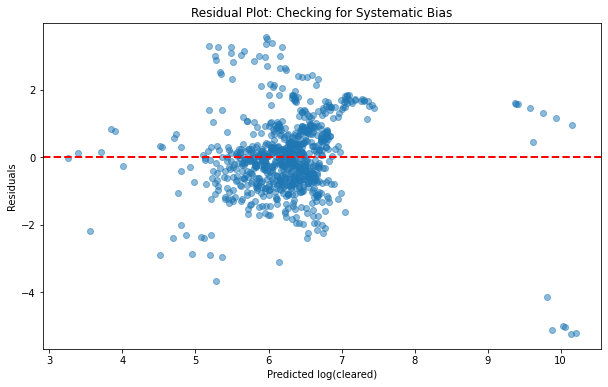

In [103]:
#residual analysis for bias check

residuals = final_model.resid
predictions = final_model.predict()

plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted log(cleared)')
plt.ylabel('Residuals')
plt.title('Residual Plot: Checking for Systematic Bias')
plt.show()

In [107]:
mean_residual = residuals.mean()
print(mean_residual)

2.704941353791912e-13


### marginal effect & hypothesis testing

In [101]:

critical_point = -model.params['officers_per_crime'] / (2 * model.params['officers_per_crime_sq'])
critical_point

1.1614609075847664

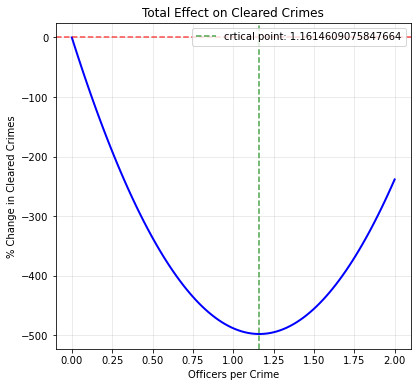

In [123]:
#marginal effect of officers and critical point:
officer_range = np.linspace(0, 2, 100)
y = (-8.574 * officer_range + 3.691 * officer_range**2)
critical_point = -model.params['officers_per_crime'] / (2 * model.params['officers_per_crime_sq'])

# Find marginal effects
marginal_effect = -8.574 + (2 * 3.691 * officer_range)

plt.figure(figsize=(14, 6))

# visualize the relationship between 
plt.subplot(1, 2, 1)
plt.plot(officer_range, y * 100, 'b-', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.axvline(x=critical_point, color='g', linestyle='--', alpha=0.7, label=f'crtical point: {critical_point}')
plt.xlabel('Officers per Crime')
plt.ylabel('% Change in Cleared Crimes')
plt.title('Total Effect on Cleared Crimes')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [92]:
#hypothesis test

mean = training['officers_per_crime'].mean()
#robust SE
se_officers = 1.536
se_officers_sq = 1.890
cov = model.cov_params().loc['officers_per_crime', 'officers_per_crime_sq']


marginal_effect = -8.574 + (2 * 3.691 * mean)

#https://stats.stackexchange.com/questions/55795/how-to-calculate-the-standard-error-of-the-marginal-effects-in-interactions-rob
var_marginal_no_cov = se_officers**2 + 4 * (mean)**2 * se_officers_sq**2
se_marginal_no_cov = np.sqrt(var_marginal_no_cov)

t = marginal_effect/se_marginal_no_cov
print(t)

-4.518751330647463
